In [59]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import requests
from requests_futures.sessions import FuturesSession
from bs4 import BeautifulSoup
import re
import urllib 
import os
import sys
import pandas as pd
import pickle
sys.path.append('/usr/local/lib/python2.7/dist-packages') 
import vincent

In [2]:
os.chdir('/home/seth/workspace_Unix/dataIncub/bbp/')

In [3]:
industry_codes_2digit=pd.read_table('/home/seth/workspace_Unix/dataIncub/bbp/refs/NAICS_2digit.txt',index_col=False, sep=';')
industry_codes_2digit['NAICS_2digit']=industry_codes_2digit['NAICS_2digit'].astype(str)
industry_codes_2digit

,NAICS_2digit,Industry_Group
0,11,"Agriculture, Forestry, Fishing and Hunting"
1,21,"Mining, Quarrying, and Oil and Gas Extraction"
2,22,Utilities
3,23,Construction
4,31,Manufacturing
5,32,Manufacturing
6,33,Manufacturing
7,42,Wholesale Trade
8,44,Retail Trade
9,45,Retail Trade


In [4]:
industry_codes=pd.read_excel('/home/seth/workspace_Unix/dataIncub/bbp/refs/6-digit_2012_Codes.xls',sheetname='2012_6-digit_industries',index_col=False, sep=';')
print industry_codes.shape
industry_codes.columns=['NAICS2012','Industry_Desc']
industry_codes=industry_codes.drop(industry_codes.index[0]) #remove empty row
industry_codes['NAICS2012']=industry_codes['NAICS2012'].astype(int).astype(str)
industry_codes.head()

(1066, 2)


,NAICS2012,Industry_Desc
1,111110,Soybean Farming
2,111120,Oilseed (except Soybean) Farming
3,111130,Dry Pea and Bean Farming
4,111140,Wheat Farming
5,111150,Corn Farming


In [5]:
##Get County FIPS IDs
county_fips_url='http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt'
county_fips=pd.read_table(county_fips_url, sep=',', header=None, names=['state_abbrev','state_fp', 'county_fp', 'countyName', 'fp_class_code'])
county_fips['state_county_code']=county_fips['state_fp']*1000+county_fips['county_fp']
county_fips['st_county_id_str']=county_fips['state_county_code'].map("{:05}".format)
county_fips.head()

,state_abbrev,state_fp,county_fp,countyName,fp_class_code,state_county_code,st_county_id_str
0,AL,1,1,Autauga County,H1,1001,01001
1,AL,1,3,Baldwin County,H1,1003,01003
2,AL,1,5,Barbour County,H1,1005,01005
3,AL,1,7,Bibb County,H1,1007,01007
4,AL,1,9,Blount County,H1,1009,01009


In [6]:
#econ example call: http://api.census.gov/data/2012/ewks?get=ST,COUNTY,EMP,RCPTOT,PAYANN,ESTAB,NAICS2012,OPTAX&for=state:*&NAICS2012=54&key=77912556e5965544a3093efa3cb2305807fbe56c
url='http://api.census.gov/data/2012/ewks?get=ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=place:*&in=state:06&&NAICS2012=31-33&key=77912556e5965544a3093efa3cb2305807fbe56c'
session = FuturesSession(max_workers=15)

# multiple resolutions available:state, county, censusplace, msa, usf, statesenate, statehouse, congdistrict, tribalnation.
# print counties_stringsDF.head(1)
# urls=(base_url+counties_stringsDF+'?format=json').tolist()

#Send multiple requests at once
futures = session.get(url) 
state_response = futures.result()

In [7]:
print state_response.url
print state_response.text[0:500]

http://api.census.gov/data/2012/ewks?get=ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=place:*&in=state:06&&NAICS2012=31-33&key=77912556e5965544a3093efa3cb2305807fbe56c
[["ST","COUNTY","NAICS2012","EMP","RCPTOT","PAYANN","ESTAB","OPTAX","NAICS2012","state","place"],
["06","001","31-33","3006","1130161","273989","50","99","31-33","06","00562"],
["06","001","31-33","39","0","1277","9","99","31-33","06","00674"],
["06","001","31-33","0","1646","0","4","99","31-33","06","02980"],
["06","001","31-33","3744","0","241146","152","99","31-33","06","06000"],
["06","001","31-33","15","1638","575","7","99","31-33","06","11964"],
["06","001","31-33","53","5349","1995","6","


In [8]:
column_names=re.split(',', 'CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX')
base_url='http://api.census.gov/data/2012/ewks?get=CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=county:*&&NAICS2012='
and_key='&key=77912556e5965544a3093efa3cb2305807fbe56c'
session = FuturesSession(max_workers=15)
urls=[]
for industry in industry_codes['NAICS2012']:
    urls.append(base_url+industry.strip()+and_key)
#     print base_url+industry+and_key
    
#Send multiple requests at once
futures = [session.get(url) for url in urls]
industry_responses = [future.result() for future in futures]

In [9]:
import pickle

In [10]:
output = open('industry_responses.pkl', 'wb')
pickle.dump(industry_responses, output)
output.close()

In [11]:
from StringIO import StringIO as strIO 

In [149]:
industryDFs=[]
for industry_response in industry_responses:
    try:
        braces_removed=re.sub('\[|]','',industry_response.text)
        industryDFs.append(pd.read_csv(strIO(braces_removed), sep=","))
    except:
        1 #print 'no data for an industry'

industryDF=pd.concat(industryDFs)

In [150]:
industryDF.shape

(407081, 13)

In [151]:
industryDF['NAICS2012']=industryDF['NAICS2012'].astype(str)

In [152]:
def pullfirst2chars(aString):
    return aString[0:2]

In [153]:
industryDF['NAICS_2digit']=industryDF['NAICS2012'].apply(pullfirst2chars)
industryDF['NAICS_2digit'].head()

0    22
1    22
2    22
3    22
4    22
Name: NAICS_2digit, dtype: object

In [154]:
industryDF=pd.merge(industryDF, industry_codes, on='NAICS2012' )
industryDF.shape

(407081, 15)

In [155]:
industryDF=pd.merge(industryDF,industry_codes_2digit, on='NAICS_2digit')
industryDF.tail()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,state,county,Unnamed: 12,NAICS_2digit,Industry_Desc,Industry_Group
407076,999,56,37,812990,0,0,0,1,T,812990,56,37,NaN,81,All Other Personal Services,Other Services (except Public Administration)
407077,999,56,39,812990,0,0,0,4,A,812990,56,39,NaN,81,All Other Personal Services,Other Services (except Public Administration)
407078,999,56,39,812990,0,0,0,4,T,812990,56,39,NaN,81,All Other Personal Services,Other Services (except Public Administration)
407079,999,56,41,812990,0,0,0,1,A,812990,56,41,NaN,81,All Other Personal Services,Other Services (except Public Administration)
407080,999,56,41,812990,0,0,0,1,T,812990,56,41,NaN,81,All Other Personal Services,Other Services (except Public Administration)


In [156]:
industryDF.NAICS_2digit.value_counts()

62    53736
42    50336
54    46515
44    41338
81    34218
71    20403
72    19592
52    19028
45    18260
53    18111
56    17649
48    16475
33    13113
61    11437
51     9300
32     7110
22     4146
31     3364
49     2950
dtype: int64

In [157]:
industryDF.shape

(407081, 16)

In [158]:
industryDF.head()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,state,county,Unnamed: 12,NAICS_2digit,Industry_Desc,Industry_Group
0,999,1,15,221111,0,0,0,1,99,221111,1,15,NaN,22,Hydroelectric Power Generation,Utilities
1,142,1,21,221111,0,0,0,2,99,221111,1,21,NaN,22,Hydroelectric Power Generation,Utilities
2,999,1,27,221111,0,0,0,1,99,221111,1,27,NaN,22,Hydroelectric Power Generation,Utilities
3,999,1,51,221111,0,0,0,3,99,221111,1,51,NaN,22,Hydroelectric Power Generation,Utilities
4,999,1,75,221111,0,0,0,1,99,221111,1,75,NaN,22,Hydroelectric Power Generation,Utilities


In [159]:
# industryDF.to_csv('CA_industryDF.csv', sep=',',index=False, encoding='utf-8' )

In [160]:
industryDF['state_county_code']= industryDF['ST']*1000+industryDF['COUNTY']
industryDF=pd.merge(industryDF, county_fips, on='state_county_code' )
industryDF['Industry_Group']=industryDF['Industry_Group'].apply(lambda x: x.strip())
by_county=industryDF[['state_county_code','Industry_Group', 'EMP','RCPTOT','PAYANN']].groupby(['state_county_code','Industry_Group']).sum()

In [161]:
industryDF.head()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,...,NAICS_2digit,Industry_Desc,Industry_Group,state_county_code,state_abbrev,state_fp,county_fp,countyName,fp_class_code,st_county_id_str
0,999,1,15,221111,0,0,0,1,99,221111,...,22,Hydroelectric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015
1,999,1,15,221115,0,0,0,1,99,221115,...,22,Wind Electric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015
2,999,1,15,221122,0,0,0,9,99,221122,...,22,Electric Power Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015
3,999,1,15,221210,0,0,0,1,99,221210,...,22,Natural Gas Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015
4,999,1,15,221310,0,0,0,1,99,221310,...,22,Water Supply and Irrigation Systems,Utilities,1015,AL,1,15,Calhoun County,H1,01015


In [162]:
by_county.head()

EMP  RCPTOT  PAYANN
state_county_code Industry_Group                                         
1001              Accommodation and Food Services     888   32462   11184
                  Finance and Insurance               242       0    8877
                  Manufacturing                         0       0       0
                  Real Estate and Rental and Leasing   36    5139     906
                  Retail Trade                        305  127404    5802

In [163]:
by_county_sum=by_county.reset_index().groupby('state_county_code').sum()

In [164]:
by_county_sum.columns=['tot_county_emp', 'tot_county_rcp', 'tot_county_ann_pay']
by_county_sum.head()

,tot_county_emp,tot_county_rcp,tot_county_ann_pay
state_county_code,,,
1001,1483,166297,27014
1003,20375,3223110,447324
1005,1238,180526,28864
1007,191,30030,3062
1009,755,76132,14648


In [165]:
county_propDF=pd.merge(by_county.reset_index(), by_county_sum.reset_index(), on='state_county_code' )

In [166]:
county_propDF['ind_prop_county_emp']=county_propDF.EMP*1.0/county_propDF.tot_county_emp
county_propDF['ind_prop_county_rcp']=county_propDF.RCPTOT*1.0/county_propDF.tot_county_rcp
county_propDF['ind_prop_county_pay']=county_propDF.PAYANN*1.0/county_propDF.tot_county_ann_pay

county_propDF.head()

,state_county_code,Industry_Group,EMP,RCPTOT,PAYANN,tot_county_emp,tot_county_rcp,tot_county_ann_pay,ind_prop_county_emp,ind_prop_county_rcp,ind_prop_county_pay
0,1001,Accommodation and Food Services,888,32462,11184,1483,166297,27014,0.598786,0.195205,0.414008
1,1001,Finance and Insurance,242,0,8877,1483,166297,27014,0.163183,0.000000,0.328607
2,1001,Manufacturing,0,0,0,1483,166297,27014,0.000000,0.000000,0.000000
3,1001,Real Estate and Rental and Leasing,36,5139,906,1483,166297,27014,0.024275,0.030903,0.033538
4,1001,Retail Trade,305,127404,5802,1483,166297,27014,0.205664,0.766123,0.214778


In [167]:
county_ind_prop_pivot=county_propDF[[ \
                                     'state_county_code',
                                     'Industry_Group',
                                     'ind_prop_county_emp',
                                     'ind_prop_county_rcp',
                                     'ind_prop_county_pay']]\
                                    .pivot(index='state_county_code', columns='Industry_Group')

In [168]:
county_ind_prop_pivot.head()

ind_prop_county_emp  \
Industry_Group    Accommodation and Food Services   
state_county_code                                   
1001                                     0.598786   
1003                                     0.430920   
1005                                     0.373183   
1007                                     0.481675   
1009                                     0.558940   

                                                                                            \
Industry_Group    Administrative and Support and Waste Management and Remediation Services   
state_county_code                                                                            
1001                                                             NaN                         
1003                                                             NaN                         
1005                                                             NaN                         
1007                                                             NaN                         
1009                                                             NaN                         

                                                                            \
Industry_Group    Arts, Entertainment, and Recreation Educational Services   
state_county_code                                                            
1001                                              NaN                  NaN   
1003                                              NaN                  NaN   
1005                                              NaN                  NaN   
1007                                              NaN                  NaN   
1009                                              NaN                  NaN   

                                                                           \
Industry_Group    Finance and Insurance Health Care and Social Assistance   
state_county_code                                                           
1001                           0.163183                               NaN   
1003                           0.059239                               NaN   
1005                           0.121971                               NaN   
1007                           0.000000                               NaN   
1009                           0.188079                               NaN   

                                             \
Industry_Group    Information Manufacturing   
state_county_code                             
1001                      NaN      0.000000   
1003                      NaN      0.006086   
1005                      NaN      0.000000   
1007                      NaN           NaN   
1009                      NaN      0.011921   

                                                                 \
Industry_Group    Other Services (except Public Administration)   
state_county_code                                                 
1001                                                        NaN   
1003                                                        NaN   
1005                                                        NaN   
1007                                                        NaN   
1009                                                        NaN   

                                                                    \
Industry_Group    Professional, Scientific, and Technical Services   
state_county_code                                                    
1001                                                           NaN   
1003                                                           NaN   
1005                                                           NaN   
1007                                                           NaN   
1009                                                           NaN   

                        ...                     ind_prop_county_pay  \
Industry_Group          ...       Health Care and Social Assista

In [169]:
county_ind_prop_pivot=county_ind_prop_pivot.fillna(0)
county_ind_prop_pivot.head()

ind_prop_county_emp  \
Industry_Group    Accommodation and Food Services   
state_county_code                                   
1001                                     0.598786   
1003                                     0.430920   
1005                                     0.373183   
1007                                     0.481675   
1009                                     0.558940   

                                                                                            \
Industry_Group    Administrative and Support and Waste Management and Remediation Services   
state_county_code                                                                            
1001                                                               0                         
1003                                                               0                         
1005                                                               0                         
1007                                                               0                         
1009                                                               0                         

                                                                            \
Industry_Group    Arts, Entertainment, and Recreation Educational Services   
state_county_code                                                            
1001                                                0                    0   
1003                                                0                    0   
1005                                                0                    0   
1007                                                0                    0   
1009                                                0                    0   

                                                                           \
Industry_Group    Finance and Insurance Health Care and Social Assistance   
state_county_code                                                           
1001                           0.163183                                 0   
1003                           0.059239                                 0   
1005                           0.121971                                 0   
1007                           0.000000                                 0   
1009                           0.188079                                 0   

                                             \
Industry_Group    Information Manufacturing   
state_county_code                             
1001                        0      0.000000   
1003                        0      0.006086   
1005                        0      0.000000   
1007                        0      0.000000   
1009                        0      0.011921   

                                                                 \
Industry_Group    Other Services (except Public Administration)   
state_county_code                                                 
1001                                                          0   
1003                                                          0   
1005                                                          0   
1007                                                          0   
1009                                                          0   

                                                                    \
Industry_Group    Professional, Scientific, and Technical Services   
state_county_code                                                    
1001                                                             0   
1003                                                             0   
1005                                                             0   
1007                                                             0   
1009                                                             0   

                        ...                     ind_prop_county_pay  \
Industry_Group          ...       Health Care and Social Assista

In [170]:
county_ind_prop_pivot.shape

(2888, 45)

In [171]:
from sklearn import cluster, mixture
from sklearn import metrics

In [172]:
km_ind_2=cluster.KMeans(n_clusters=2,n_init=20).fit(county_ind_prop_pivot)
km_ind_3=cluster.KMeans(n_clusters=3,n_init=20).fit(county_ind_prop_pivot)
km_ind_4=cluster.KMeans(n_clusters=4,n_init=20).fit(county_ind_prop_pivot)
km_ind_5=cluster.KMeans(n_clusters=5,n_init=20).fit(county_ind_prop_pivot)
km_ind_6=cluster.KMeans(n_clusters=6,n_init=20).fit(county_ind_prop_pivot)
km_ind_7=cluster.KMeans(n_clusters=7,n_init=20).fit(county_ind_prop_pivot)
km_ind_8=cluster.KMeans(n_clusters=8,n_init=20).fit(county_ind_prop_pivot)
km_ind_9=cluster.KMeans(n_clusters=9,n_init=20).fit(county_ind_prop_pivot)
km_ind_10=cluster.KMeans(n_clusters=10,n_init=20).fit(county_ind_prop_pivot)


In [173]:
kmean_test=pd.DataFrame([
        ("KM 2 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_2.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 3 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_3.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 4 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_4.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 5 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_5.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 6 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_6.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 7 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_7.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 8 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_8.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 9 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_9.predict(county_ind_prop_pivot), metric='euclidean')),
        ("KM 10 cluster",  metrics.silhouette_score(county_ind_prop_pivot, km_ind_10.predict(county_ind_prop_pivot), metric='euclidean'))
], columns=["Model", "Silhouette"])

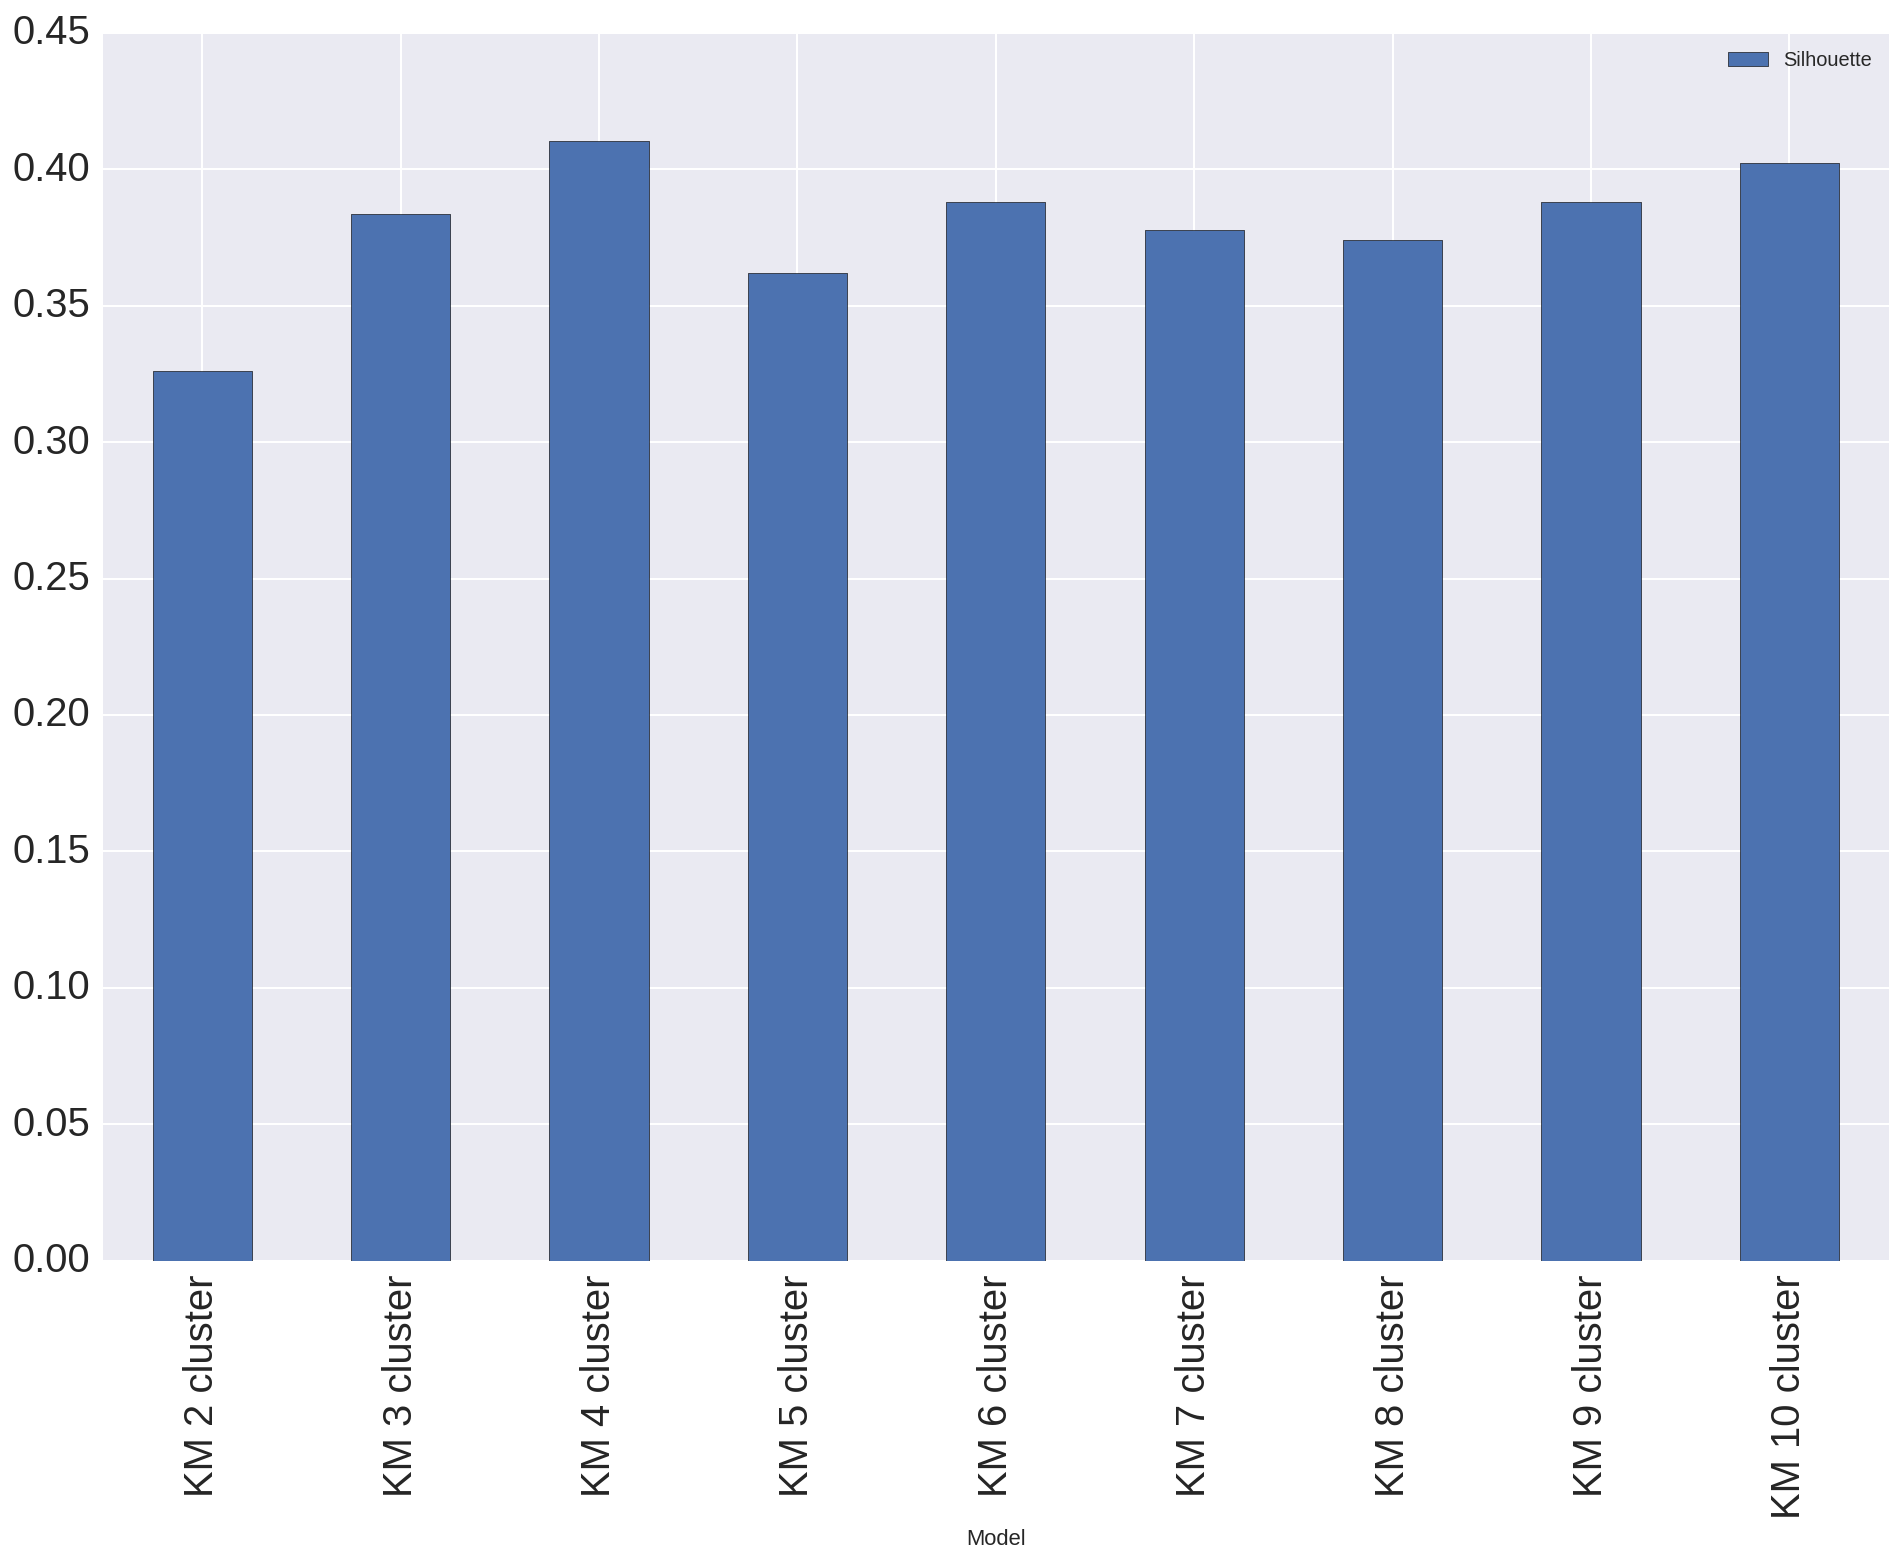

In [174]:
p1=kmean_test.plot(x="Model", y="Silhouette", kind="bar", figsize=(16,11),fontsize=20)
p1

In [175]:
fig = p1.get_figure()
fig.savefig('keans_cluster_compare.pdf', pad_inches='tight')

In [176]:
gmm_ind_2=mixture.GMM(n_components=2,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_3=mixture.GMM(n_components=3,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_4=mixture.GMM(n_components=4,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_5=mixture.GMM(n_components=5,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_6=mixture.GMM(n_components=6,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_7=mixture.GMM(n_components=7,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_8=mixture.GMM(n_components=8,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_9=mixture.GMM(n_components=9,n_init=20).fit(county_ind_prop_pivot)
gmm_ind_10=mixture.GMM(n_components=10,n_init=20).fit(county_ind_prop_pivot)

#               'GMM_ind_prop_5': mixture.GMM(n_components=5,max_iter=10),
#               'GMM_ind_prop_8': mixture.GMM(n_components=8, max_iter=10)}

In [177]:
# metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_2.predict(county_ind_prop_pivot), metric='euclidean')

In [178]:
gmm_test=pd.DataFrame([
        ("GMM 2 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_2.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 3 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_3.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 4 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_4.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 5 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_5.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 6 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_6.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 7 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_7.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 8 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_8.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 9 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_9.predict(county_ind_prop_pivot), metric='euclidean')),
        ("GMM 10 cluster",  metrics.silhouette_score(county_ind_prop_pivot, gmm_ind_10.predict(county_ind_prop_pivot), metric='euclidean'))
], columns=["Model", "Silhouette"])

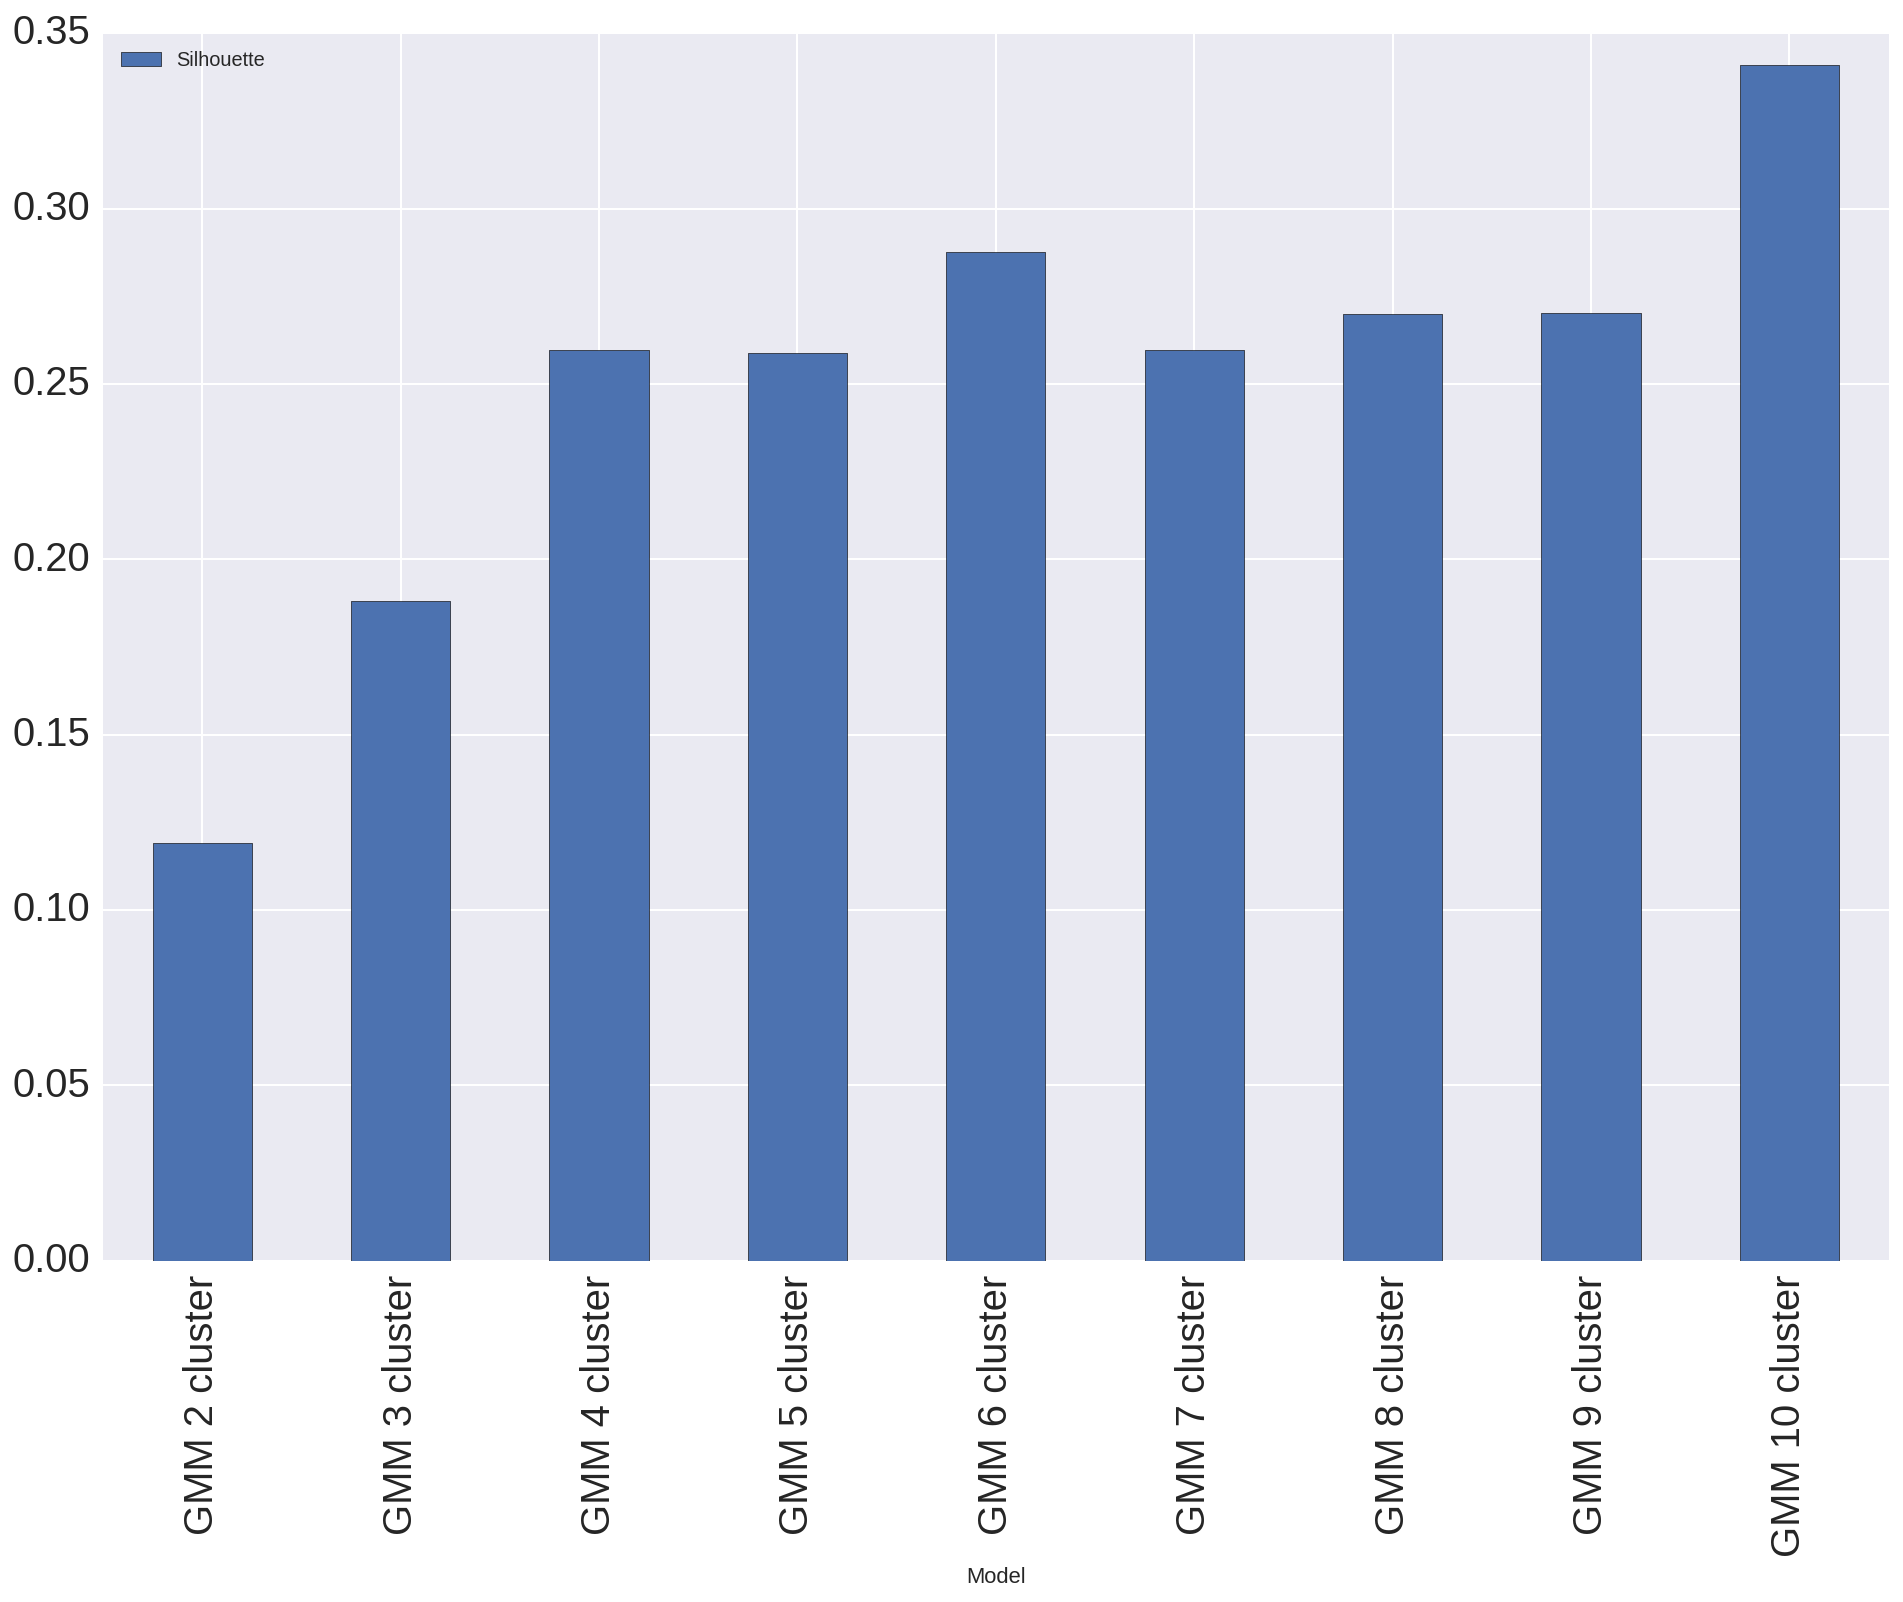

In [179]:
p2=gmm_test.plot(x="Model", y="Silhouette", kind="bar", figsize=(16,11),fontsize=20)

In [180]:
fig = p2.get_figure()
fig.savefig('gmm_components.pdf', pad_inches='tight')

(array([  319.,   555.,  1727.,   287.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

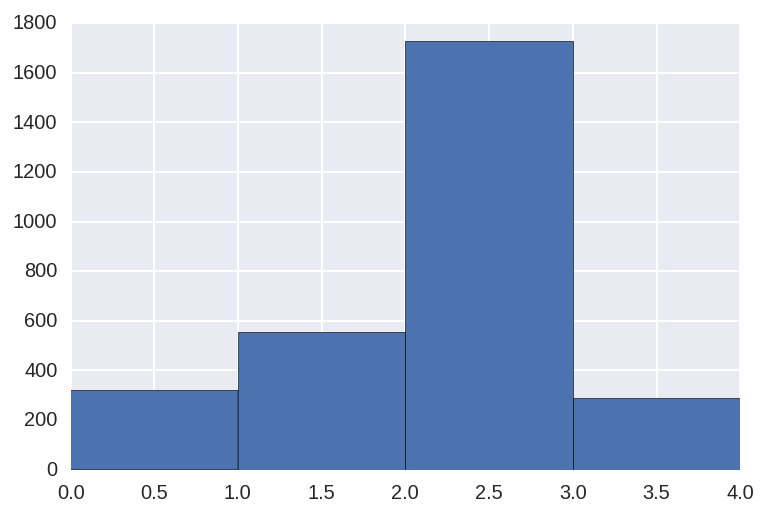

In [181]:
import numpy as np
pl.hist(km_ind_4.predict(county_ind_prop_pivot), bins=[0,1,2,3,4])

In [182]:
county_ind_prop_pivot['kmeans_4_cluster']=km_ind_4.predict(county_ind_prop_pivot)

In [183]:
county_ind_prop_pivot['kmeans_4_cluster'].value_counts()

2    1727
1     555
0     319
3     287
dtype: int64

In [184]:
county_ind_prop_pivot.head()

ind_prop_county_emp  \
Industry_Group    Accommodation and Food Services   
state_county_code                                   
1001                                     0.598786   
1003                                     0.430920   
1005                                     0.373183   
1007                                     0.481675   
1009                                     0.558940   

                                                                                            \
Industry_Group    Administrative and Support and Waste Management and Remediation Services   
state_county_code                                                                            
1001                                                               0                         
1003                                                               0                         
1005                                                               0                         
1007                                                               0                         
1009                                                               0                         

                                                                            \
Industry_Group    Arts, Entertainment, and Recreation Educational Services   
state_county_code                                                            
1001                                                0                    0   
1003                                                0                    0   
1005                                                0                    0   
1007                                                0                    0   
1009                                                0                    0   

                                                                           \
Industry_Group    Finance and Insurance Health Care and Social Assistance   
state_county_code                                                           
1001                           0.163183                                 0   
1003                           0.059239                                 0   
1005                           0.121971                                 0   
1007                           0.000000                                 0   
1009                           0.188079                                 0   

                                             \
Industry_Group    Information Manufacturing   
state_county_code                             
1001                        0      0.000000   
1003                        0      0.006086   
1005                        0      0.000000   
1007                        0      0.000000   
1009                        0      0.011921   

                                                                 \
Industry_Group    Other Services (except Public Administration)   
state_county_code                                                 
1001                                                          0   
1003                                                          0   
1005                                                          0   
1007                                                          0   
1009                                                          0   

                                                                    \
Industry_Group    Professional, Scientific, and Technical Services   
state_county_code                                                    
1001                                                             0   
1003                                                             0   
1005                                                             0   
1007                                                             0   
1009                                                             0   

                        ...        ind_prop_county_pay                \
Industry_Group          ...                Information Manufact

In [185]:
county_ind_prop_emp=county_ind_prop_pivot['ind_prop_county_emp'].copy()
county_ind_prop_emp.head()
county_ind_prop_emp['kmeans_4_cluster']=county_ind_prop_pivot['kmeans_4_cluster']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc86a16b750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc86e71d8d0>]], dtype=object)

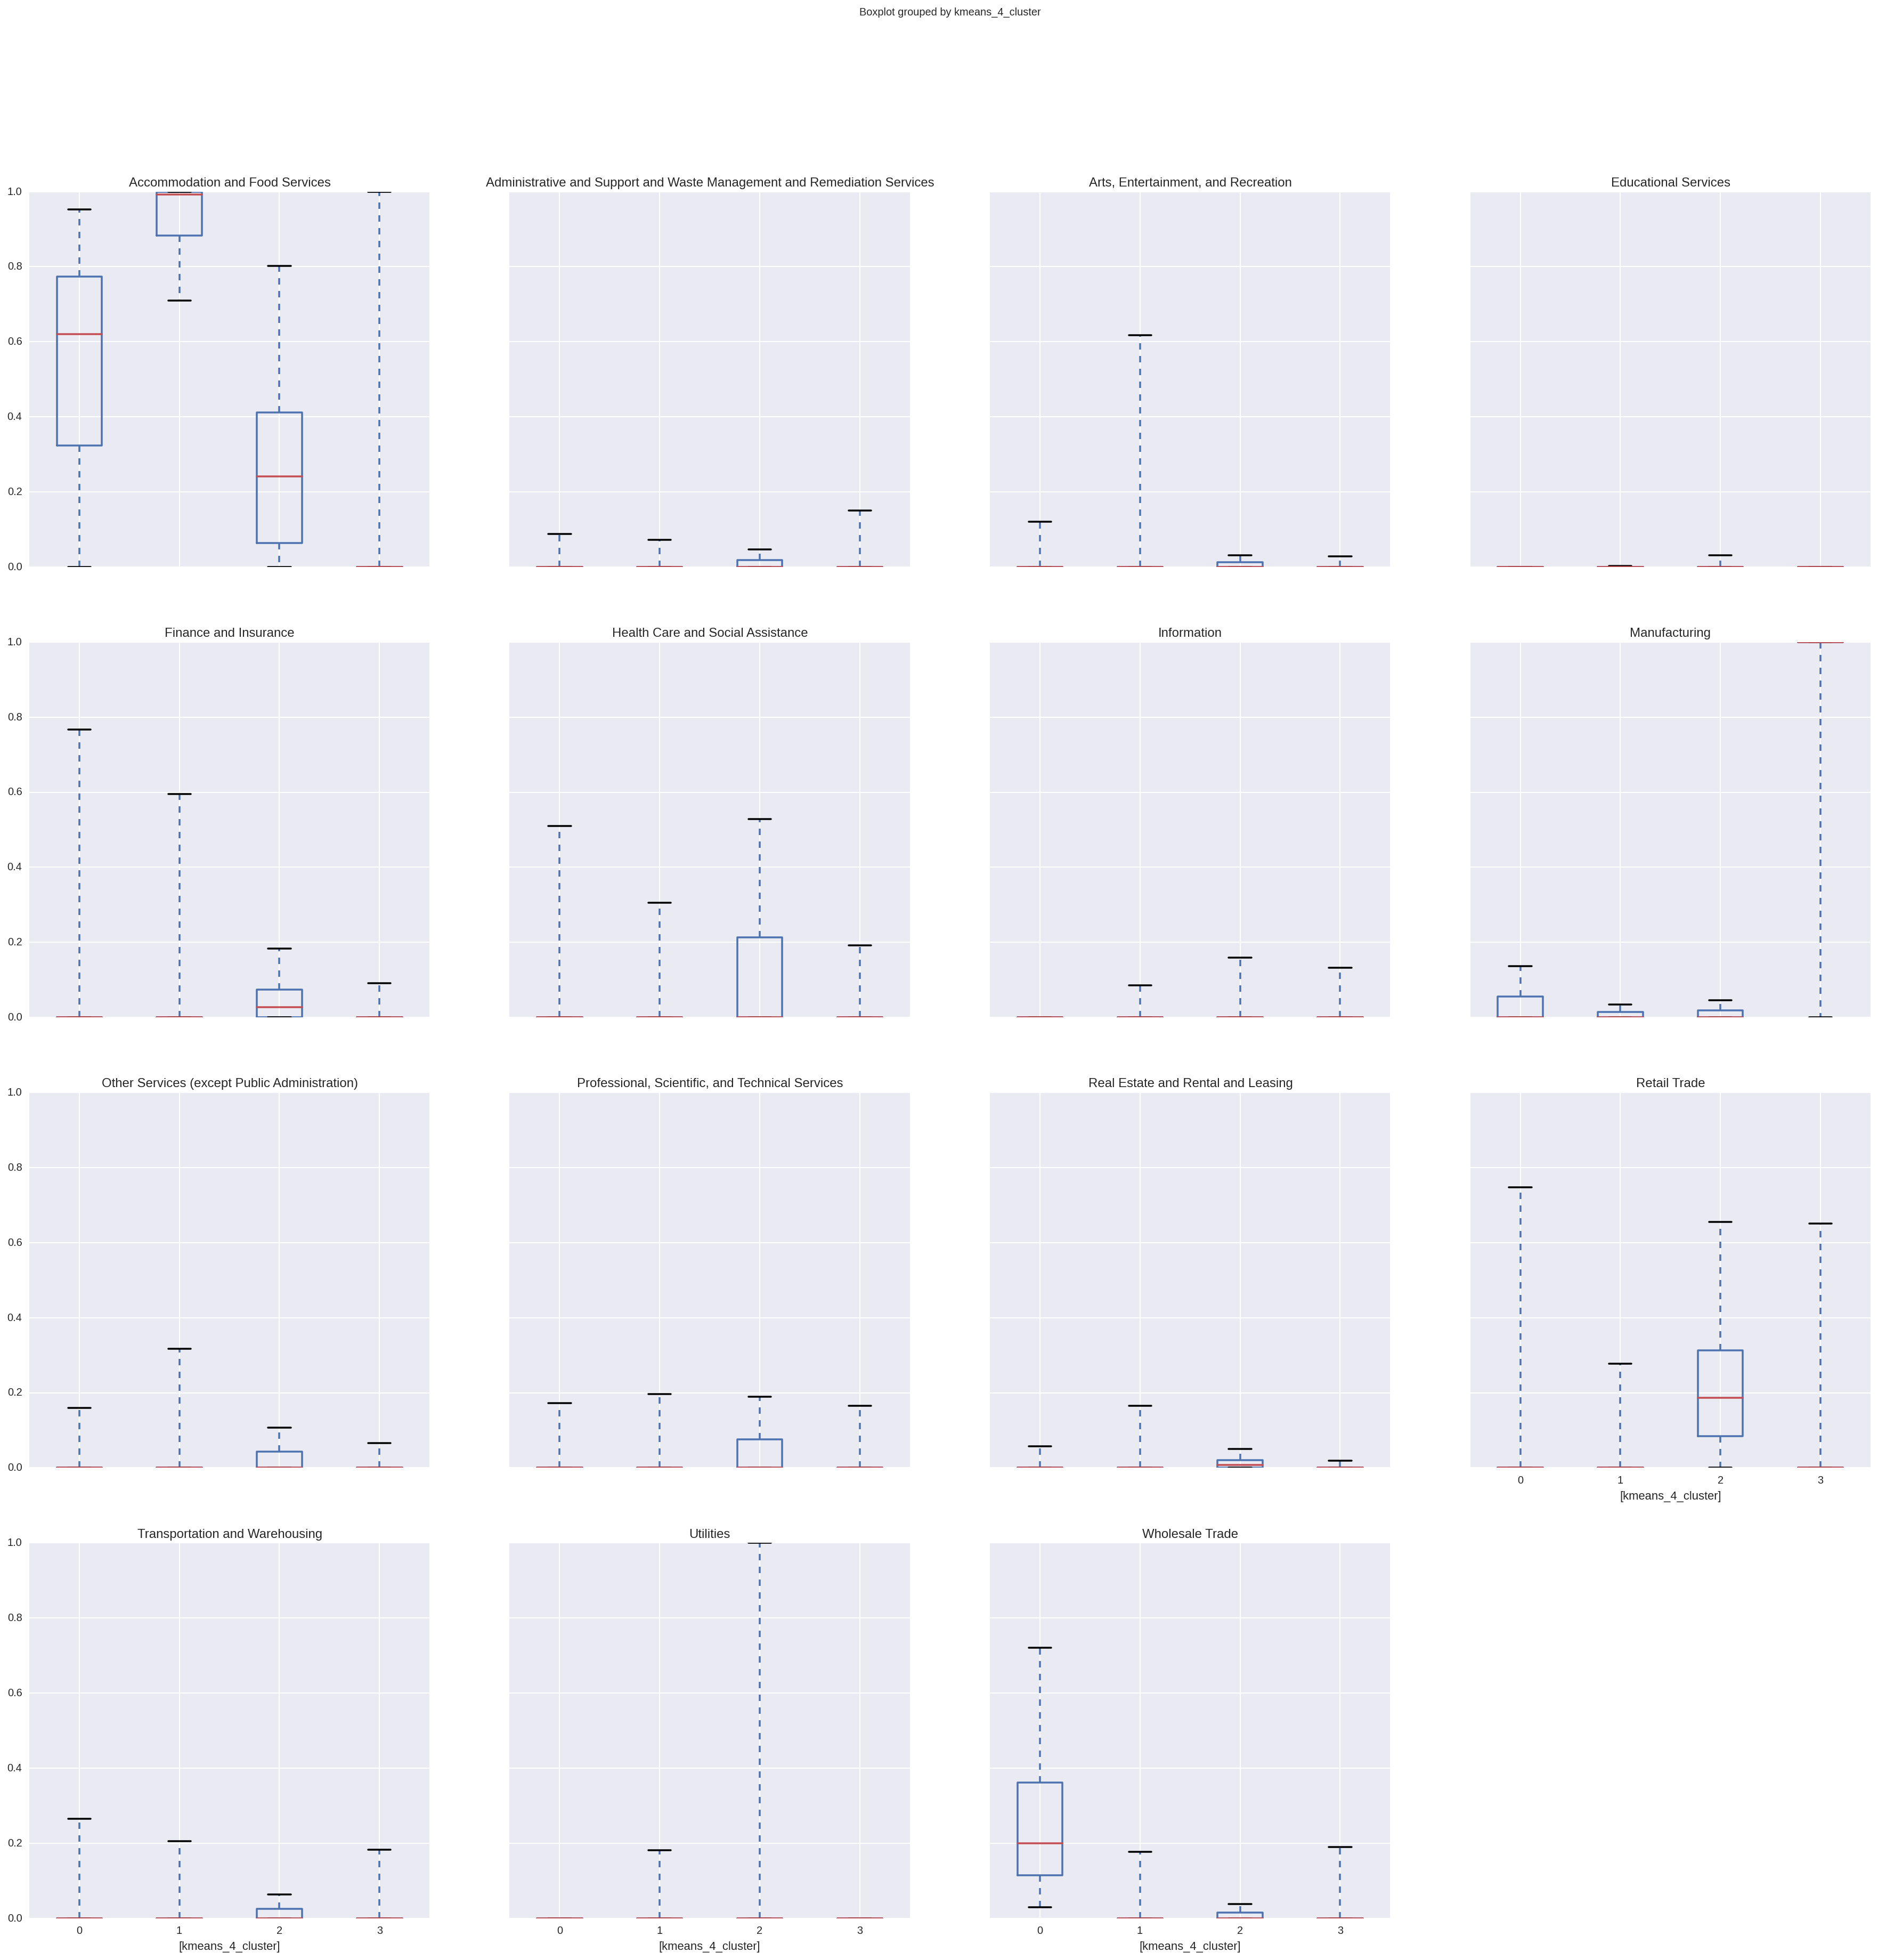

In [207]:
county_ind_prop_emp.boxplot(by='kmeans_4_cluster', figsize=(30,30))

In [205]:
# pl.savefig('kmeans_4_emp.pdf', pad_inches='tight')

In [189]:
county_ind_prop_rcp=county_ind_prop_pivot['ind_prop_county_rcp'].copy()
county_ind_prop_rcp.head()
county_ind_prop_rcp['kmeans_4_cluster']=county_ind_prop_pivot['kmeans_4_cluster']

p4=county_ind_prop_rcp.boxplot(by='kmeans_4_cluster', figsize=(30,30))

In [197]:
county_ind_prop_pay=county_ind_prop_pivot['ind_prop_county_pay'].copy()
county_ind_prop_pay.head()
county_ind_prop_pay['kmeans_4_cluster']=county_ind_prop_pivot['kmeans_4_cluster']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc87314df90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc876645150>]], dtype=object)

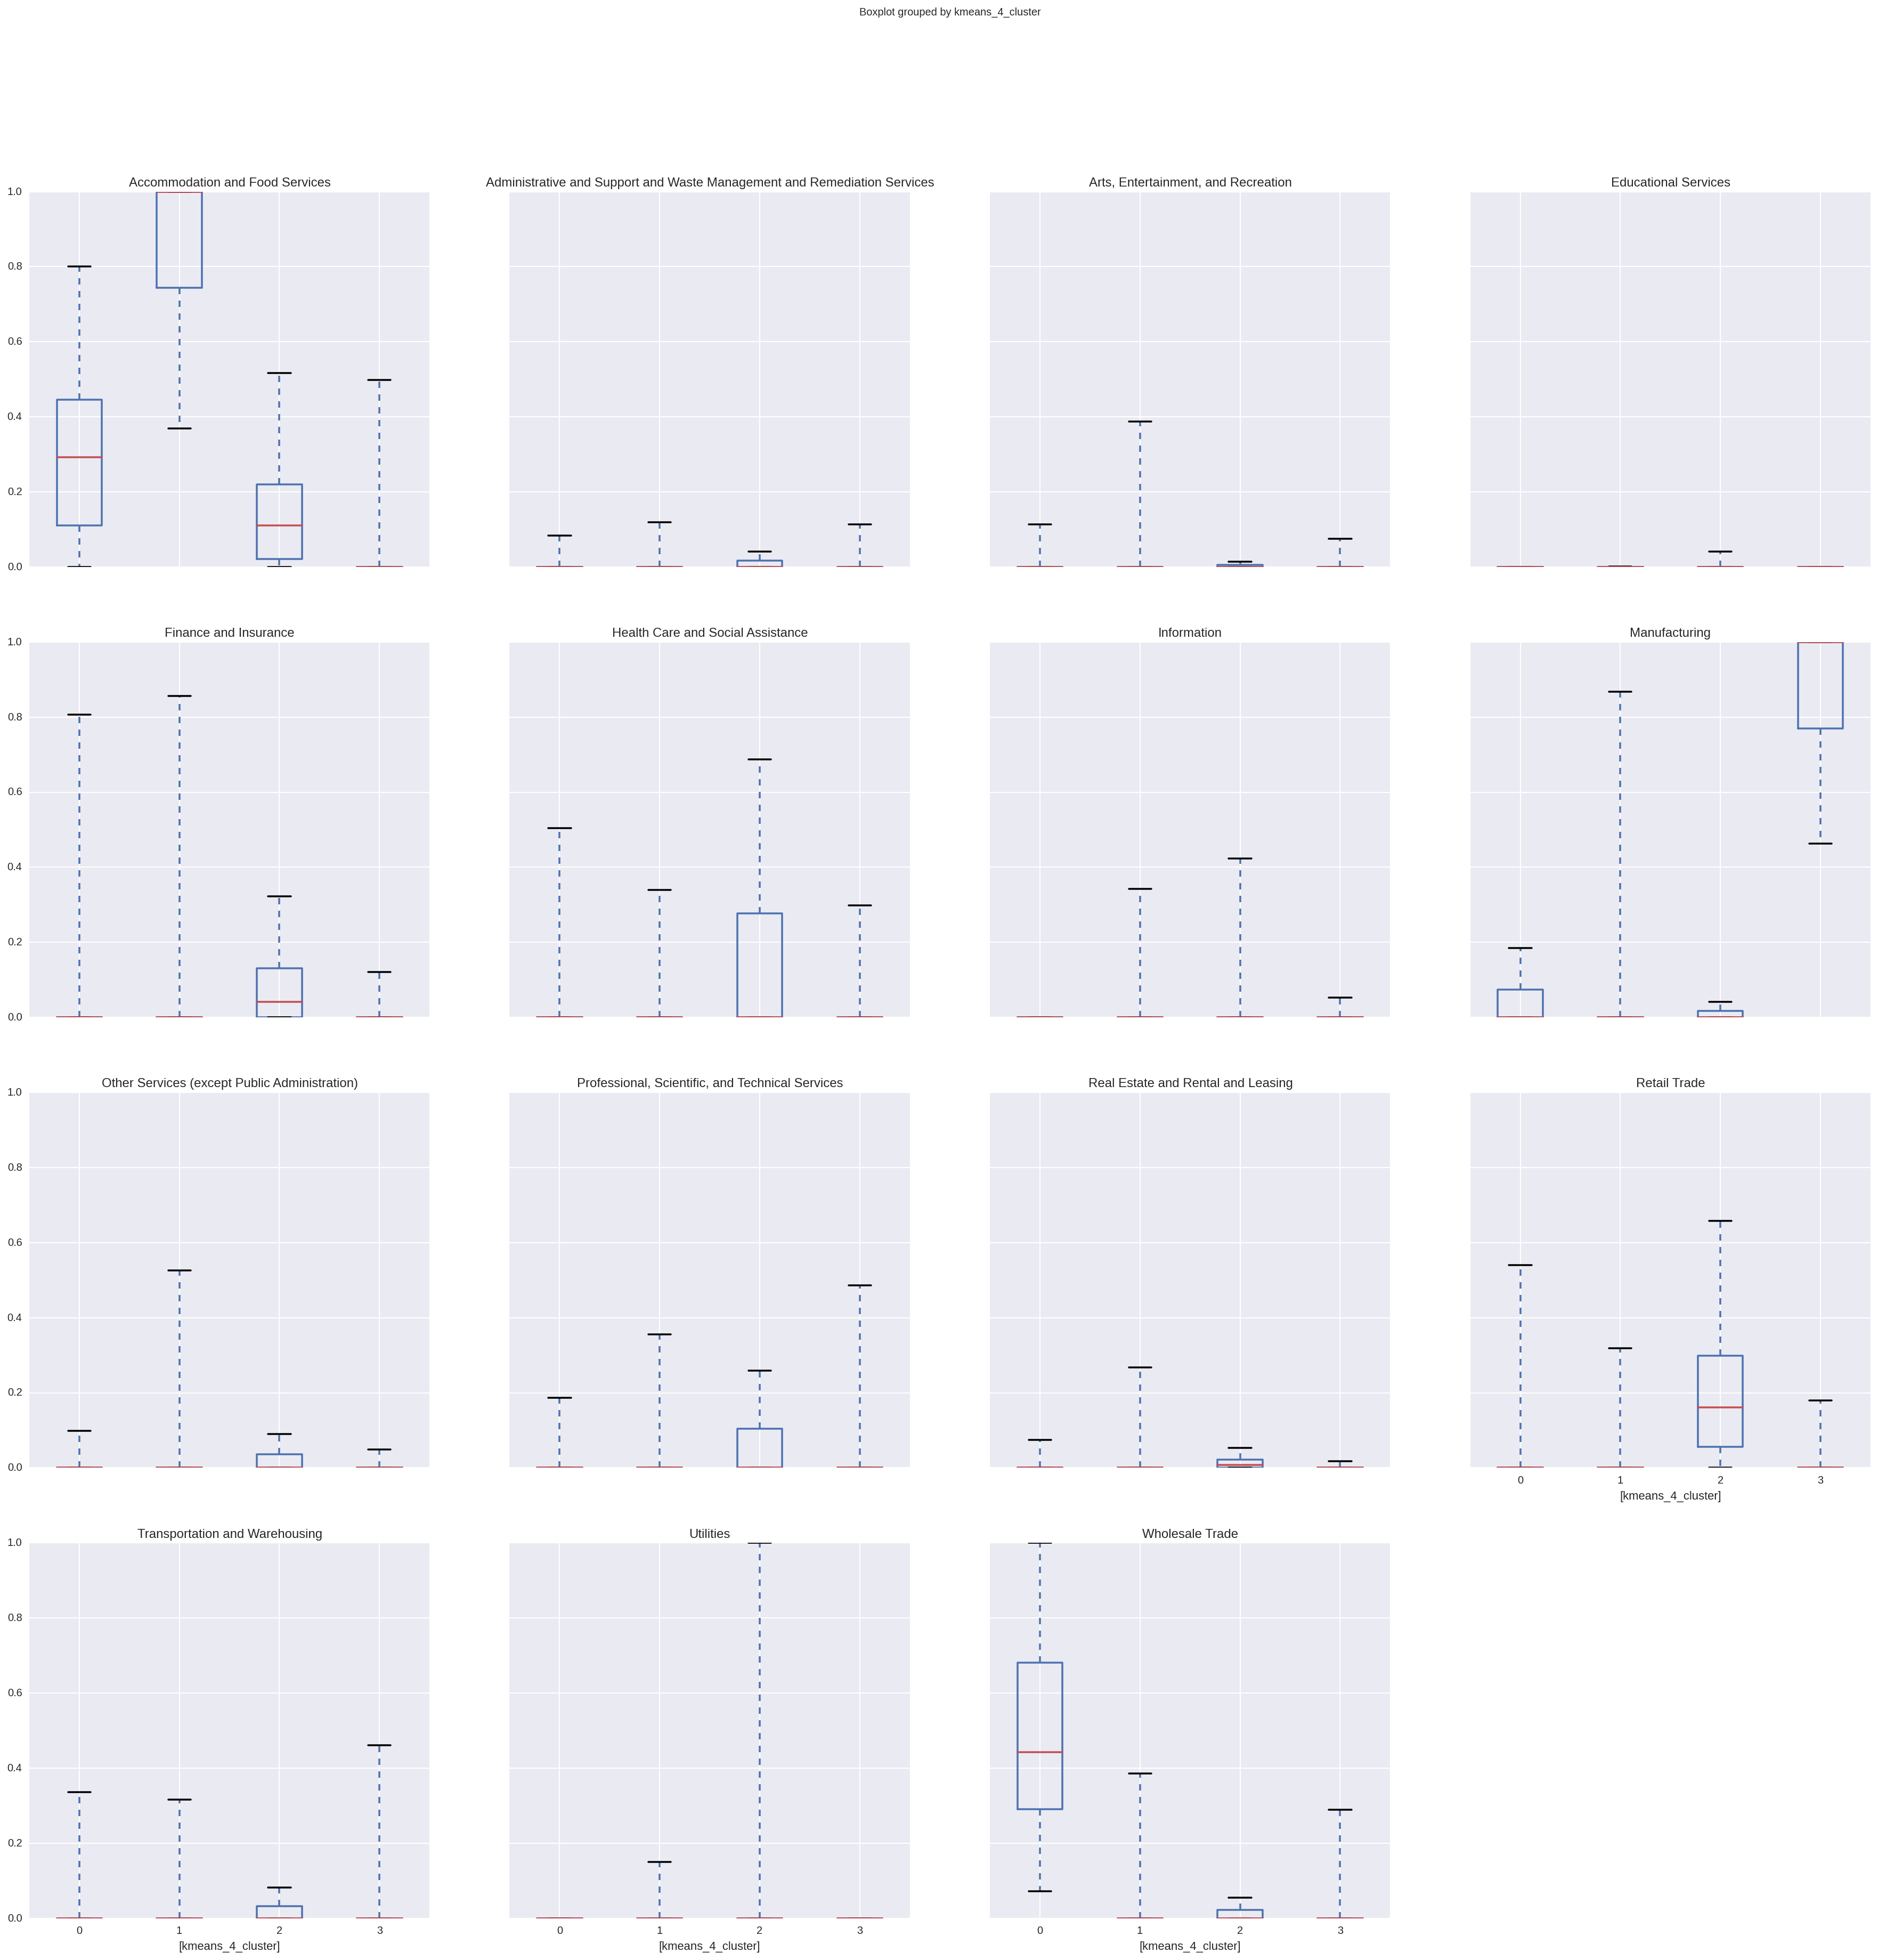

In [198]:
county_ind_prop_pay.boxplot(by='kmeans_4_cluster', figsize=(30,30))

In [201]:
county_ind_prop_pivot.to_csv('county_ind_prop_pivot.csv', sep=',',index=True, encoding='utf-8' )

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,...,Industry_Desc,Industry_Group,state_county_code,state_abbrev,state_fp,county_fp,countyName,fp_class_code,st_county_id_str,ST_tot_emp
0,999,1,15,221111,0,0,0,1,99,221111,...,Hydroelectric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015,305349
1,999,1,15,221115,0,0,0,1,99,221115,...,Wind Electric Power Generation,Utilities,1015,AL,1,15,Calhoun County,H1,01015,305349
2,999,1,15,221122,0,0,0,9,99,221122,...,Electric Power Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015,305349
3,999,1,15,221210,0,0,0,1,99,221210,...,Natural Gas Distribution,Utilities,1015,AL,1,15,Calhoun County,H1,01015,305349
4,999,1,15,221310,0,0,0,1,99,221310,...,Water Supply and Irrigation Systems,Utilities,1015,AL,1,15,Calhoun County,H1,01015,305349


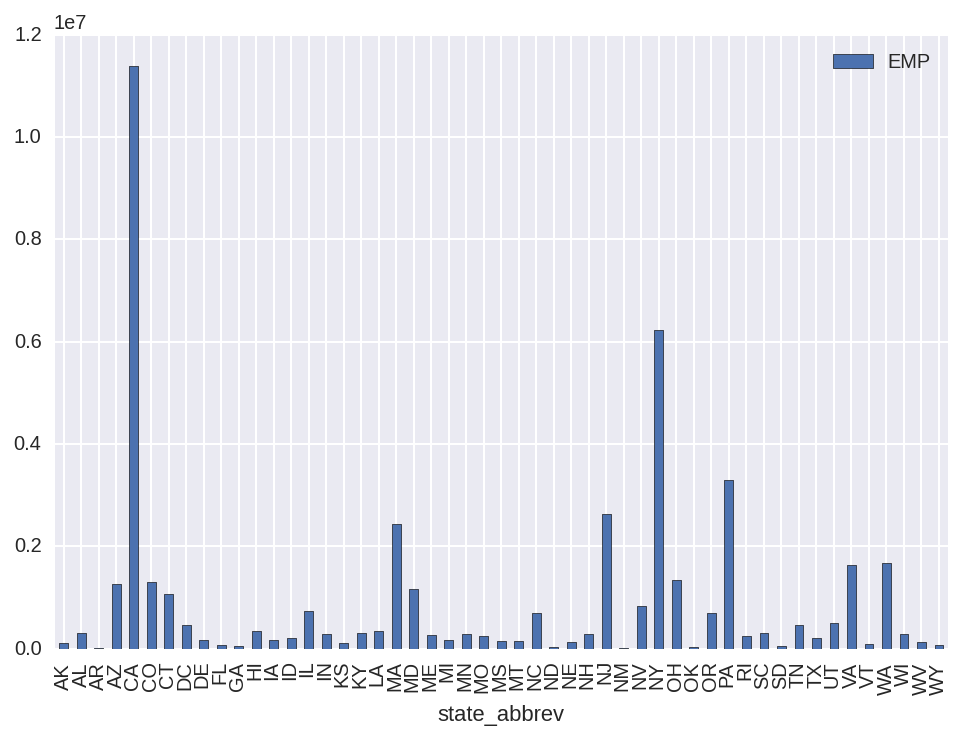

In [66]:
workforce_by_state=by_ST.sum()
p1=workforce_by_state.plot(kind='bar')
workforce_by_state=workforce_by_state.reset_index()
workforce_by_state.columns=['state_abbrev', 'ST_tot_emp']
workforce_by_state.head()
industryDF=pd.merge(industryDF, workforce_by_state, on='state_abbrev' )
industryDF.head()

In [67]:
emp_by_industry=industryDF[['Industry_Group', 'EMP']].groupby('Industry_Group')

,Industry_Group,Industry_tot_emp
0,Accommodation and Food Services,7896691
1,Administrative and Support and Waste Manag...,2873452
2,"Arts, Entertainment, and Recreation",1037027
3,Educational Services,403788
4,Finance and Insurance,2035837


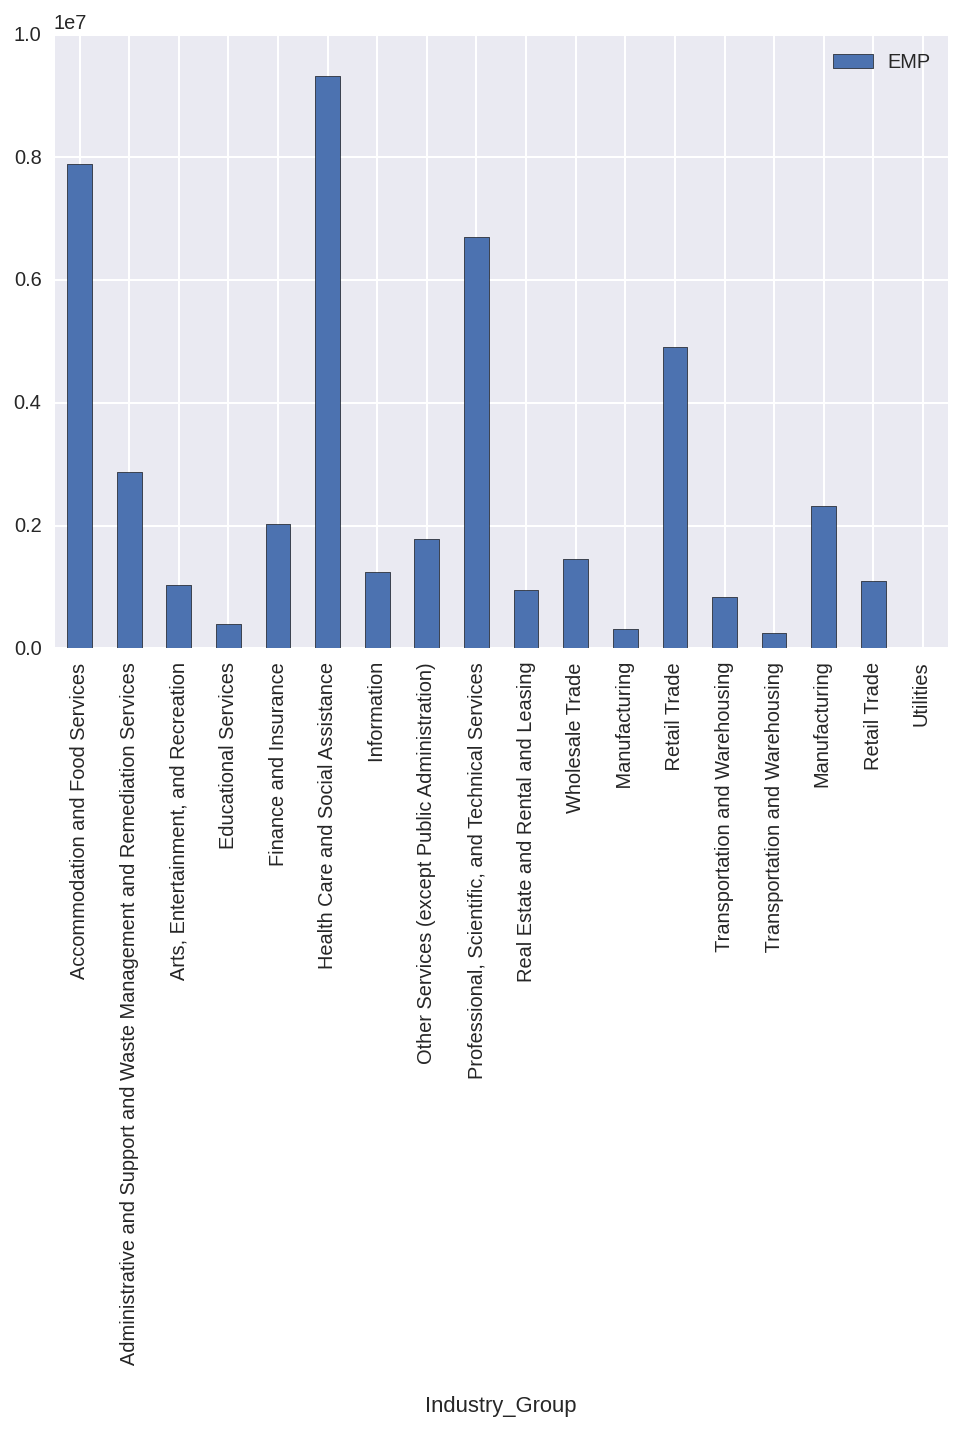

In [68]:
workforce_by_industry=emp_by_industry.sum()
workforce_by_industry.plot(kind='bar')
workforce_by_industry=workforce_by_industry.reset_index()
workforce_by_industry.columns=['Industry_Group', 'Industry_tot_emp']
workforce_by_industry.head()

In [69]:
industryDF.tail()

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,...,Industry_Desc,Industry_Group,state_county_code,state_abbrev,state_fp,county_fp,countyName,fp_class_code,st_county_id_str,ST_tot_emp
360862,999,35,3,423940,0,0,0,1,10,423940,...,"Jewelry, Watch, Precious Stone, and Precious M...",Wholesale Trade,35003,NM,35,3,Catron County,H1,35003,8014
360863,999,35,53,424490,0,0,0,1,10,424490,...,Other Grocery and Related Products Merchant Wh...,Wholesale Trade,35053,NM,35,53,Socorro County,H1,35053,8014
360864,999,35,19,424520,0,0,0,1,10,424520,...,Livestock Merchant Wholesalers,Wholesale Trade,35019,NM,35,19,Guadalupe County,H1,35019,8014
360865,999,35,23,424710,0,0,0,1,10,424710,...,Petroleum Bulk Stations and Terminals,Wholesale Trade,35023,NM,35,23,Hidalgo County,H1,35023,8014
360866,999,35,23,424920,0,0,0,1,10,424920,...,"Book, Periodical, and Newspaper Merchant Whole...",Wholesale Trade,35023,NM,35,23,Hidalgo County,H1,35023,8014


In [70]:
industryDF=pd.merge(industryDF, workforce_by_industry, on='Industry_Group' )

In [71]:

# workforce_by_state.columns=['index', 'state_abbrev', 'ST_tot_emp']
workforce_by_state.head()

,state_abbrev,ST_tot_emp
0,AK,112359
1,AL,305349
2,AR,19109
3,AZ,1271948
4,CA,11393870


In [72]:
industryDF.columns

Index([u'CSA', u'ST', u'COUNTY', u'NAICS2012', u'EMP', u'RCPTOT', u'PAYANN',
       u'ESTAB', u'OPTAX', u'NAICS2012.1', u'state', u'county', u'Unnamed: 12',
       u'NAICS_2digit', u'Industry_Desc', u'Industry_Group',
       u'state_county_code', u'state_abbrev', u'state_fp', u'county_fp',
       u'countyName', u'fp_class_code', u'st_county_id_str', u'ST_tot_emp',
       u'Industry_tot_emp'],
      dtype='object')

In [73]:
by_both=industryDF[['ST','Industry_Group', 'EMP']].groupby(['ST','Industry_Group'])

In [74]:
output = open('industryDF.pkl', 'wb')
pickle.dump(industryDF, output)
output.close()

In [75]:
emp_by_county=industryDF[['state_county_code', 'EMP']].groupby('state_county_code')

In [76]:
workforce_by_county=emp_by_county.sum()

In [77]:
workforce_by_county=emp_by_county.sum()
# workforce_by_county.plot(kind='bar')
workforce_by_county=workforce_by_county.reset_index()
workforce_by_county.columns=['state_county_code', 'county_tot_emp']

In [78]:
workforce_by_county.head()

,state_county_code,county_tot_emp
0,1001,1241
1,1003,19168
2,1005,1087
3,1007,191
4,1009,613


In [ ]:
http://api.census.gov/data/2012/ewks?get=EMP,NAICS2012_TTL,OPTAX,GEO_TTL&for=place:07000&in=state:01+county:073&NAICS2012=31-33

In [10]:
column_names=re.split(',', 'CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX')
base_url='http://api.census.gov/data/2012/ewks?get=CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX&for=place:*&in=state:06&NAICS2012='
and_key='&key=77912556e5965544a3093efa3cb2305807fbe56c'
session = FuturesSession(max_workers=15)
urls=[]
for industry in industry_codes['NAICS2012']:
    urls.append(base_url+industry.strip()+and_key)
#     print base_url+industry+and_key
    
#Send multiple requests at once
futures = [session.get(url) for url in urls]
industry_responses = [future.result() for future in futures]

In [15]:
industryDF=pd.merge(industryDF, workforce_by_county, on='st_county_id' )

u'[["CSA","ST","COUNTY","NAICS2012","EMP","RCPTOT","PAYANN","ESTAB","OPTAX","NAICS2012","state","place"],\n["488","6","1","611519","0","0","0","1","A","611519","6","00562"],\n["488","6","1","611519","0","0","0","1","T","611519","6","00562"],\n["488","6","1","611519","0","0","0","1","A","611519","6","02980"],\n["488","6","1","611519","0","0","0","1","T","611519","6","02980"],\n["488","6","1","611519","0","0","0","8","A","611519","6","06000"],\n["488","6","1","611519","0","0","0","3","T","611519","6","060'

In [13]:
industryDF['prop_emp_ind_county']=industryDF['EMP']*1.0/industryDF['county_tot_emp']

In [ ]:
output = open('industryDF_with_Aggs.pkl', 'wb')
pickle.dump(industryDF, output)
output.close()

In [3]:
pkl_file = open('industryDF_with_Aggs.pkl', 'rb')
industryDF = pickle.load(pkl_file)

In [5]:
industryDF.columns

Index([u'CSA', u'ST', u'COUNTY', u'NAICS2012', u'EMP', u'RCPTOT', u'PAYANN',
       u'ESTAB', u'OPTAX', u'NAICS2012.1', u'state', u'county', u'Unnamed: 12',
       u'NAICS_2digit', u'Industry_Desc', u'Industry_Group', u'st_county_id',
       u'state_abbrev', u'state_fp', u'county_fp', u'countyName',
       u'fp_class_code', u'st_county_id_str', u'ST_tot_emp', u'county_tot_emp',
       u'prop_emp_ind_county'],
      dtype='object')

In [14]:
industryDF['st_county_id', 'IndustryGroup', 'EMP']

,CSA,ST,COUNTY,NAICS2012,EMP,RCPTOT,PAYANN,ESTAB,OPTAX,NAICS2012.1,...,st_county_id,state_abbrev,state_fp,county_fp,countyName,fp_class_code,st_county_id_str,ST_tot_emp,county_tot_emp,prop_emp_ind_county
0,999,1,15,221111,0,0,0,1,99,221111,...,1015,AL,1,15,Calhoun County,H1,01015,305349,7896,0
1,999,1,15,221115,0,0,0,1,99,221115,...,1015,AL,1,15,Calhoun County,H1,01015,305349,7896,0
2,999,1,15,221122,0,0,0,9,99,221122,...,1015,AL,1,15,Calhoun County,H1,01015,305349,7896,0
3,999,1,15,221210,0,0,0,1,99,221210,...,1015,AL,1,15,Calhoun County,H1,01015,305349,7896,0
4,999,1,15,221310,0,0,0,1,99,221310,...,1015,AL,1,15,Calhoun County,H1,01015,305349,7896,0


In [10]:
industryDF[['st_county_id_str', 'Industry_Group','prop_emp_ind_county']]

,st_county_id_str,Industry_Group,prop_emp_ind_county
0,01015,Utilities,0.000000
1,01015,Utilities,0.000000
2,01015,Utilities,0.000000
3,01015,Utilities,0.000000
4,01015,Utilities,0.000000
5,01015,Manufacturing,0.009119
6,01015,Manufacturing,0.000000
7,01015,Manufacturing,0.030268
8,01015,Manufacturing,0.000000
9,01015,Manufacturing,0.011398
